In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image # Pemrosesan Gambar
import os
import pandas as pd
import matplotlib.pyplot as plt # Visualisasi Data
import numpy as np # Operasi aljabar linear
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os 
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [6]:
!wget install https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, pred_and_plot,walk_through_dir

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2025-02-15 07:37:44--  http://install/
Resolving install (install)... failed: Name or service not known.
wget: unable to resolve host address 'install'
--2025-02-15 07:37:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.1'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-15 07:37:44 (31.8 MB/s) - 'helper_functions.py.1' saved [10246/10246]

FINISHED --2025-02-15 07:37:44--
Total wall clock time: 0.06s
Downloaded: 1 files, 10K in 0s (31.8 MB/s)


In [7]:
# Walk through each directory
# data-slayer-2-0-machine-learning-competition
train_data = "/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train"
test_data = "/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/test"
walk_through_dir(train_data)
walk_through_dir(test_data)

There are 2 directories and 0 images in '/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train'.
There are 25 directories and 0 images in '/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train/fall'.
There are 0 directories and 47 images in '/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train/fall/2_right_falls'.
There are 0 directories and 43 images in '/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train/fall/2_forward_falls'.
There are 0 directories and 48 images in '/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train/fall/1_left_falls'.
There are 0 directories and 61 images in '/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train/fall/4_left_falls'.
There are 0 directories and 66 images in '/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train/fall/2_standing_falls'.
There are 0 directories and 74 images in '/k

In [8]:
from pathlib import Path
import os.path

In [9]:
def convert_path_to_df(dataset, is_test=False):
    image_dir = Path(dataset)

    # Get filepaths for image files
    filepaths = list(image_dir.glob(r'**/*.JPG')) + \
            list(image_dir.glob(r'**/*.jpg')) + \
            list(image_dir.glob(r'**/*.jpeg')) + \
            list(image_dir.glob(r'**/*.PNG')) + \
            list(image_dir.glob(r'**/*.png')) + \
            list(image_dir.glob(r'**/*.bmp')) + \
            list(image_dir.glob(r'**/*.tiff'))
    if is_test:
        # If it's test data, only return filepaths
        filepaths = pd.Series(filepaths, name='Filepath').astype(str)
        image_df = pd.DataFrame({'Filepath': filepaths})
    else:
        # For train data, extract labels from immediate parent folder
        labels = list(map(lambda x: x.parts[-3], filepaths))
        filepaths = pd.Series(filepaths, name='Filepath').astype(str)
        labels = pd.Series(labels, name='Label')
        image_df = pd.concat([filepaths, labels], axis=1)

    return image_df

# Load train data (with labels)
train_df = convert_path_to_df(train_data, is_test=False)
print("Train Data:")
print(train_df.head())

# Load test data (no labels)
test_df = convert_path_to_df(test_data, is_test=True)
print("Test Data:")
print(test_df.head())

Train Data:
                                            Filepath Label
0  /kaggle/input/demon-slayer/data-slayer-2-0-mac...  fall
1  /kaggle/input/demon-slayer/data-slayer-2-0-mac...  fall
2  /kaggle/input/demon-slayer/data-slayer-2-0-mac...  fall
3  /kaggle/input/demon-slayer/data-slayer-2-0-mac...  fall
4  /kaggle/input/demon-slayer/data-slayer-2-0-mac...  fall
Test Data:
                                            Filepath
0  /kaggle/input/demon-slayer/data-slayer-2-0-mac...
1  /kaggle/input/demon-slayer/data-slayer-2-0-mac...
2  /kaggle/input/demon-slayer/data-slayer-2-0-mac...
3  /kaggle/input/demon-slayer/data-slayer-2-0-mac...
4  /kaggle/input/demon-slayer/data-slayer-2-0-mac...


In [10]:
test_df

,Filepath
0,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
1,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
2,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
3,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
4,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
...,...
2147,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
2148,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
2149,/kaggle/input/demon-slayer/data-slayer-2-0-mac...
2150,/kaggle/input/demon-slayer/data-slayer-2-0-mac...


In [11]:
train_df

,Filepath,Label
0,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
1,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
2,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
3,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
4,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
...,...,...
5791,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
5792,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
5793,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall
5794,/kaggle/input/demon-slayer/data-slayer-2-0-mac...,fall


In [12]:
# Check for corrupted images within the dataset
from PIL import UnidentifiedImageError

path = Path(train_data).rglob("*.jpg")
for img_p in path:
    try:
        img = Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

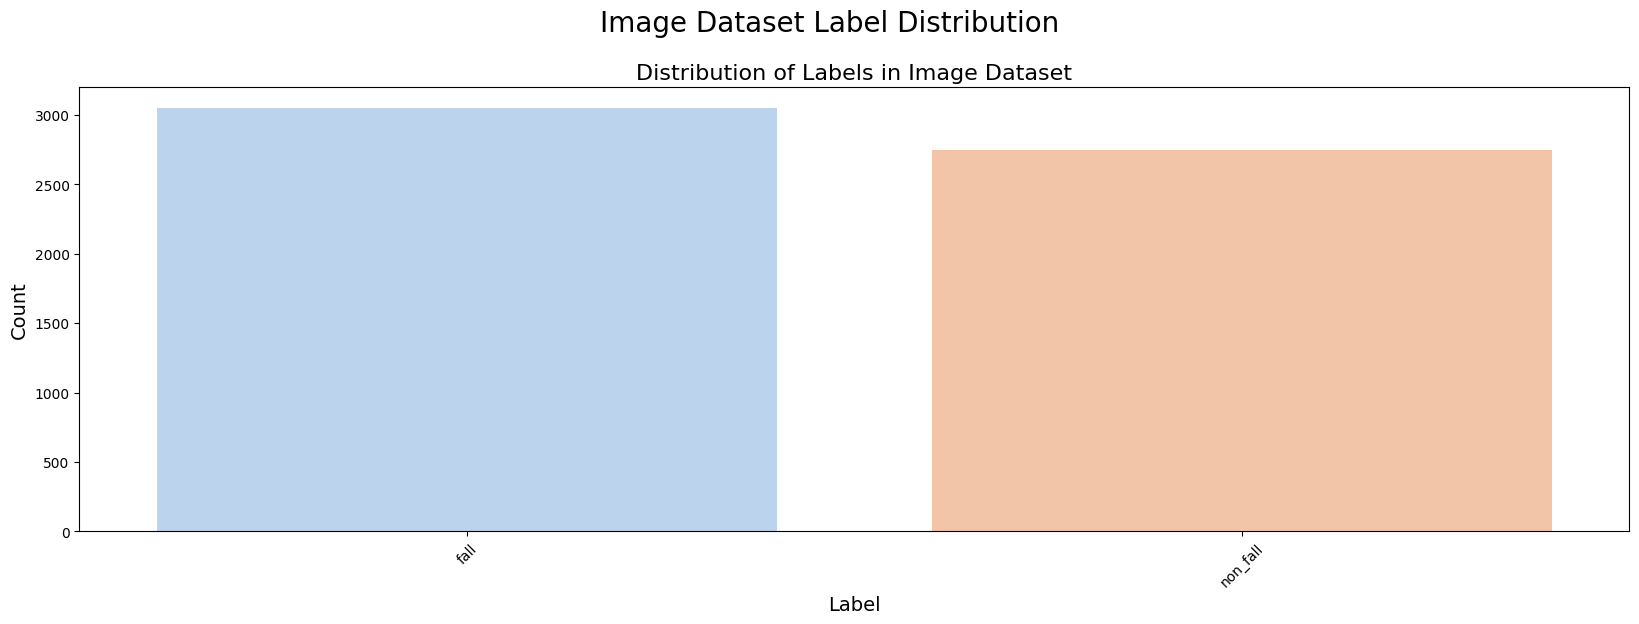

In [13]:
# Get the value counts for each label
label_counts = train_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

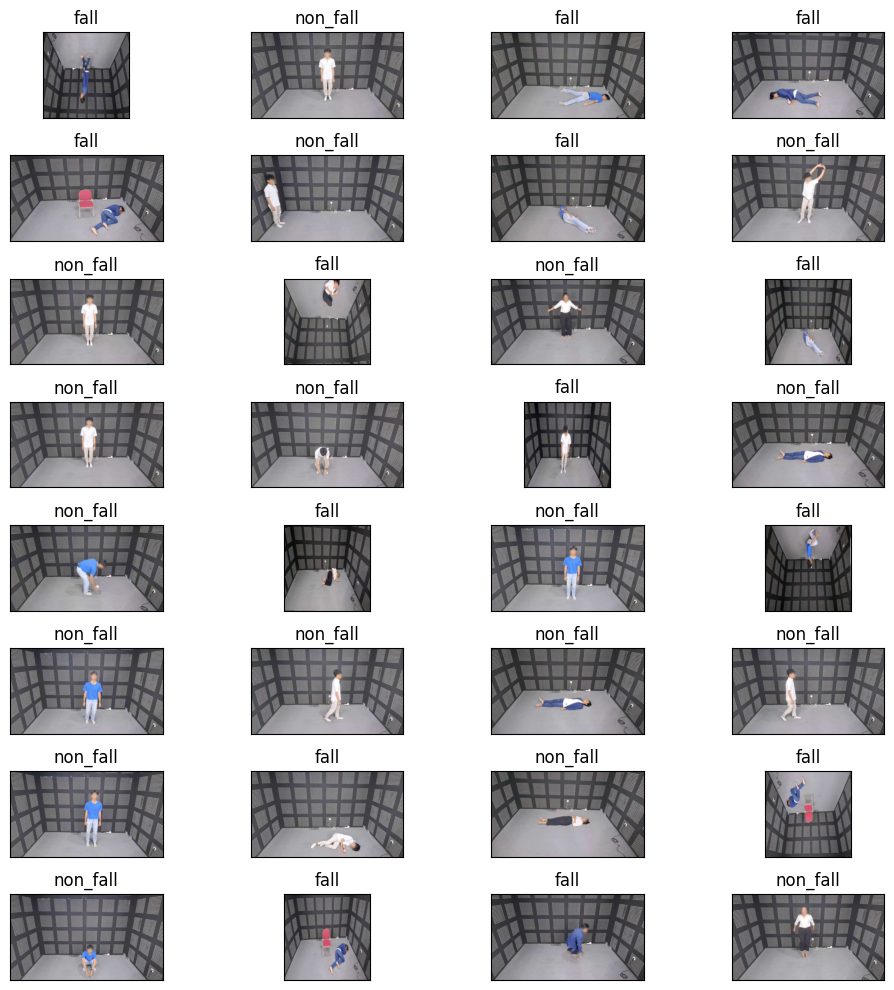

In [14]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(train_df), 32)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[random_index[i]]))
    ax.set_title(train_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=42)

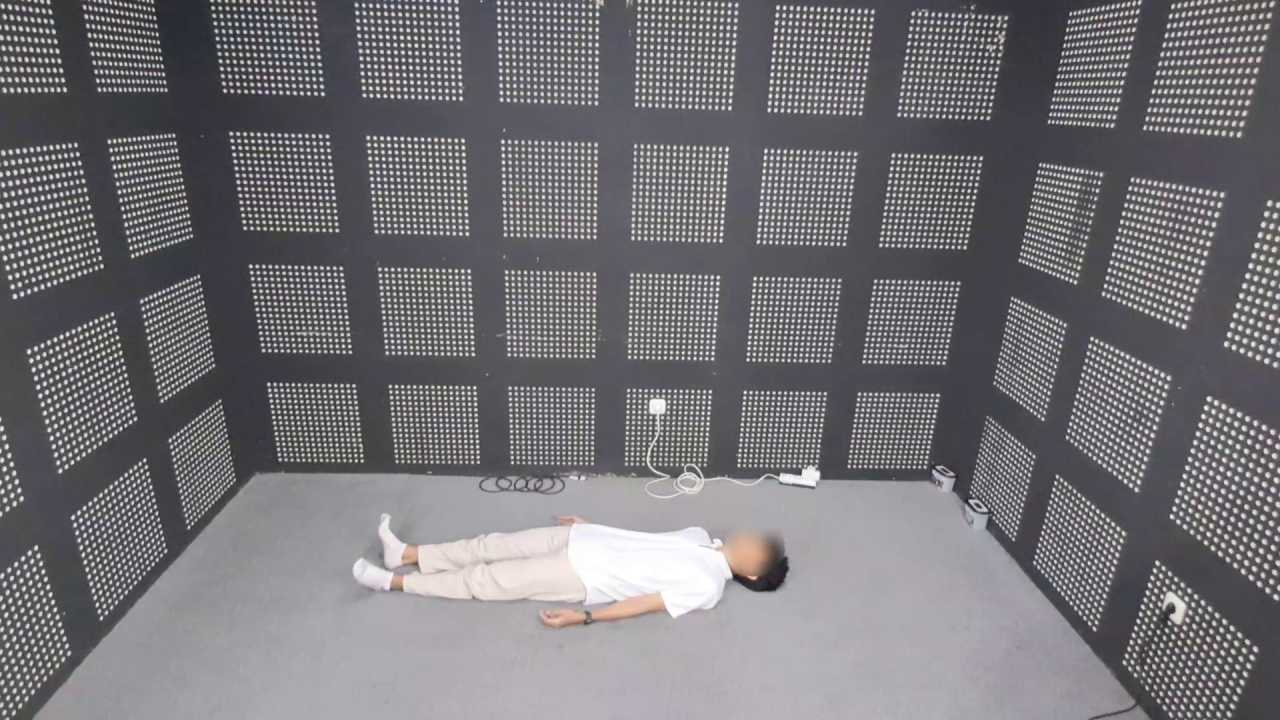

In [16]:
Image.open(train_df.iloc[0]['Filepath'])

In [17]:
BATCH_SIZE=32

In [18]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_column, label_column=None, transform=None):
        self.dataframe = dataframe
        self.image_column = image_column
        self.label_column = label_column
        self.transform = transform
        
        # Inisialisasi LabelEncoder jika ada label
        if self.label_column:
            self.label_encoder = LabelEncoder()
            # Fit label encoder dengan data label yang ada
            self.label_encoder.fit(self.dataframe[self.label_column])  # Contoh: ['fall', 'non_fall']

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load image
        img_path = self.dataframe.iloc[idx][self.image_column]
        image = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load label if available
        if self.label_column:
            label = self.dataframe.iloc[idx][self.label_column]
            label = self.label_encoder.transform([label])[0]  # Encode label as 0 or 1
            return image, torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        else:
            return image  # Return image only if label_column is None (e.g., for test data)

# Define transformations (resize and normalize)
transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=0.2),
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ImageNet
])

# Training dataset and DataLoader
train_dataset = CustomDataset(
    dataframe=train_df, 
    image_column='Filepath', 
    label_column='Label', 
    transform=transform
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=16,  # Ganti sesuai dengan batch size yang diinginkan
    shuffle=True, 
    num_workers=4
)

# Validation dataset and DataLoader (commented out for now)
val_dataset = CustomDataset(
    dataframe=val_df, 
    image_column='Filepath', 
    label_column='Label', 
    transform=transform
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16,  # Ganti sesuai dengan batch size yang diinginkan
    shuffle=False, 
    num_workers=4
)

# Test dataset and DataLoader
test_dataset = CustomDataset(
    dataframe=test_df, 
    image_column='Filepath', 
    label_column=None,  # No labels for test data
    transform=transform
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=16,  # Ganti sesuai dengan batch size yang diinginkan
    shuffle=False,  # Biasanya untuk data uji, shuffle diatur ke False
    num_workers=4
)

In [19]:
print(val_df.iloc[0]['Filepath'])

/kaggle/input/demon-slayer/data-slayer-2-0-machine-learning-competition/train/fall/5_outbound_falls/273_1.png


In [20]:
import timm
import torch.nn as nn

# Membuat model EfficientNet-B0 dengan bobot pre-trained
model = timm.create_model('efficientnet_b0', pretrained=True)

# Mengubah lapisan classifier agar sesuai dengan jumlah kelas yang diinginkan
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)  # Ganti dengan jumlah kelas Anda (misal: 2)

# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Model siap digunakan untuk training atau inference


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [21]:
criterion = nn.CrossEntropyLoss()

# Optimizer (misalnya Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Bisa sesuaikan learning rate

In [22]:
for param in model.parameters():
    param.requires_grad = False

# Hanya melatih lapisan terakhir (classifier)
for param in model.classifier.parameters():
    param.requires_grad = True

# Optimizer hanya diperbarui untuk parameter yang tidak dibekukan
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

In [23]:
for param in model.parameters():
    param.requires_grad = True

# Optimizer sekarang dapat mengupdate seluruh parameter model
optimizer = optim.Adam(model.parameters(), lr=1e-5)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


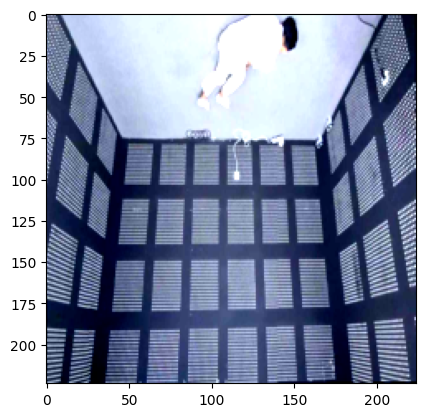

Label: 0


In [24]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Fungsi untuk menampilkan gambar
def imshow(img):
    img = img / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (H, W, C)
    plt.show()

# Menampilkan gambar pertama dalam batch
imshow(images[0])  # Gambar pertama dalam batch
print(f"Label: {labels[0]}")  # Label gambar pertama

In [25]:
num_epochs = 9
for epoch in range(num_epochs):
    model.train()  # Set model ke mode training
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Memindahkan input dan label ke device secara terpisah
        inputs = inputs.to(device)  # Memindahkan input (image) ke device
        labels = labels.to(device)  # Memindahkan label ke device

        optimizer.zero_grad()  # Mengatur gradien ke nol

        outputs = model(inputs)  # Melakukan forward pass
        loss = criterion(outputs, labels)  # Hitung loss

        loss.backward()  # Melakukan backward pass untuk mengupdate gradien
        optimizer.step()  # Update parameter model

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")


Epoch 1/9, Loss: 0.4312771735198659, Accuracy: 84.56671779141104%
Epoch 2/9, Loss: 0.18663624690079983, Accuracy: 94.74693251533742%
Epoch 3/9, Loss: 0.08245019990368033, Accuracy: 97.98696319018404%
Epoch 4/9, Loss: 0.04838287299698893, Accuracy: 98.83052147239263%
Epoch 5/9, Loss: 0.03477147679655967, Accuracy: 99.079754601227%
Epoch 6/9, Loss: 0.020358160427740083, Accuracy: 99.50153374233129%
Epoch 7/9, Loss: 0.016159289083700696, Accuracy: 99.67407975460122%
Epoch 8/9, Loss: 0.012442170774979814, Accuracy: 99.78911042944786%
Epoch 9/9, Loss: 0.006565303545915864, Accuracy: 99.90414110429448%


In [26]:
# testscore = []
# for input, label in train_loader:
#     # Misalnya multi-label classification
#     testscore.append(label.cpu().numpy())  # Mengambil seluruh label dalam array numpy
# testscore_flat = np.concatenate(testscore)
# print(testscore_flat)
# print(testscore_flat)

In [27]:
# print(testscore)

In [28]:
model.eval()  # Set model ke mode evaluasi
predictions = []

with torch.no_grad():  # Nonaktifkan perhitungan gradien
    for inputs in test_loader:
        inputs = inputs.to(device)  # Kirim ke device (GPU/CPU)
        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Prediksi kelas dengan probabilitas tertinggi
        predictions.extend(predicted.cpu().numpy())  # Simpan hasil prediksi

# Menampilkan hasil prediksi
print(predictions)

[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 

In [29]:
#test value sama si test predict
from sklearn.metrics import f1_score
f1=f1_score(testscore_flat,predictions,average='macro')
print(f1)

NameError: name 'testscore_flat' is not defined

In [30]:
submit=pd.read_csv("/kaggle/input/data-slayer-fix/data-slayer-2-0-machine-learning-competition/sample_submission.csv")
submit.head()

,id,label
0,4a73abcd02.jpg,0
1,266bdb8d70.jpg,0
2,1389b9fb66.jpg,0
3,7e1c35f2e6.jpg,0
4,8271bebf8f.jpg,0


In [31]:
for i in range(len(submit)):
    submit.loc[i, 'label'] = predictions[i]  # Prediksi jenis
submit.to_csv('/kaggle/working/submissionc.csv', index=False)

In [32]:
tu=pd.read_csv('/kaggle/working/submissionc.csv')
tu.head()

,id,label
0,4a73abcd02.jpg,0
1,266bdb8d70.jpg,0
2,1389b9fb66.jpg,1
3,7e1c35f2e6.jpg,0
4,8271bebf8f.jpg,1
